In this note we perform a Bayesian hiearchical modeling of mouse longevity data. We show how
such modeling can be performed in Julia using the Turing.jl and associated packages.  We also
discuss data analysis choices and compare the output from different models. The main analysis
is a Bayesian two-level model assuming normally distributed residuals. We tweak this model
by allowing flat-tailed residuals, and by allowing the residual variance to differ by cluster.

The computations here were performed using Julia with 16 threads used for computation.
Choosing the tuning parameters and starting values for the computations was chellenging.

# BXD longevity data 

This data comes from a mouse longevity study conducted by Rob Williams and colleagues. About 1700 mice from about 110 mouse inbred strains were followed until their death. About half the mice were fed a high-fat diet (HF) and the rest were fed the control or "chow" diet (CD). The mouse strains are derived from a cross between the B6 and DBA mouse strains.  In that sense, the strains are a sample from the population of all possible strains that can be made from crossing those two strains. Mice from the same strain are expected to have more similar longevity.  In this study mice (first level units) are clustered within strains (second level units).

We want to know the impact of strain genetic background and diet on longevity, and if the effect of diet depends on strain.

In [29]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()

  Activating project at `~/GIT/bayes`


In [30]:
using MixedModels, GLM, CSV, DataFrames, Weave
using FreqTables, CategoricalArrays, StatsPlots, StatsModels, Statistics, StatsBase
using LinearAlgebra, Turing, Distributions, Random, Optim

In [31]:
gr()
# to operate in headless mode      
# https://discourse.julialang.org/t/generation-of-documentation-fails-qt-qpa-xcb-could-not-connect-to-display/60988
ENV["GKSwstype"] = "100"
ENV["COLUMNS"] = "200"
set_chunk_defaults!(:line_width => 400)
set_chunk_defaults!(:term => true)

We read in the data and look at the column names.

In [4]:
lifespan = CSV.read("/home/sen/uthsc/data/bxd/longevity/AgingBXD_LongevityData_3Feb2023.csv",
    DataFrame,header=4);
names(lifespan)

14-element Vector{String}:
 "Index"
 "EarTagNumberCurrent"
 "EarTagNumberOriginal"
 "StrainNameCurrent"
 "Sex"
 "DietCode"
 "AgeAtDeath (days)"
 "CauseOfDeath"
 "DateOfBirth"
 "DateDietStart"
 "DateOfDeath"
 "AgeAtSettingUp (days)"
 "Column13"
 "Column14"

In [5]:
first(lifespan) |> (x->show(x,allcols=true))

DataFrameRow
 Row │ Index  EarTagNumberCurrent  EarTagNumberOriginal  StrainNameCurrent  Sex    DietCode  AgeAtDeath (days)  CauseOfDeath  DateOfBirth  DateDietStart  DateOfDeath  AgeAtSettingUp (days)  Column13  Column14 
     │ Int64  Int64                Int64                 String15           Bool   String3   Int64              String15      String15     String15       String15     Int64                  Missing   Missing  
─────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │     1                 2534                  2534  BXD29              false  CD                     1250  Natural       10/04/2015   01/15/2016     03/07/2019                     103   missing   missing 

We rename a few columns for convenience and summarize the data by diet and strain.

In [6]:
rename!( lifespan, 7=>:lifetime, 4=>:strain, 6=>:diet );

In [7]:
strainN = combine(groupby(lifespan,
        r"strain|diet"), :lifetime => (x-> length(collect(skipmissing(x)))) => :n);
strainN4 = unstack(strainN,:strain,:diet,:n) |>
       (df->subset(df,:HF => (h-> h .> 3),skipmissing=true)) |> 
       (df->subset(df,:CD => (c-> c .> 3),skipmissing=true)) |>
       (df->subset(df,:strain => (x->startswith.(x,"BXD"))));

In [8]:
lifespanN4 = semijoin(lifespan,strainN4,on=:strain);

In [9]:
strainDietTableN4 = combine(groupby(lifespanN4,r"^diet|^strain"),  
    :lifetime => (x->length(collect(skipmissing(x)))) => :n, 
    :lifetime => (x->mean(skipmissing(x))) => :mean, 
    :lifetime => (x->std(skipmissing(x))) => :sd,
    :lifetime => (x->median(skipmissing(x))) => :median);

In [10]:
strainDietTableN4 |> (df->first(df,8))

Row,strain,diet,n,mean,sd,median
,String15,String3,Int64,Float64,Float64,Float64
1,BXD29,CD,16,803.625,200.859,778.5
2,BXD29,HF,16,697.062,129.668,707.0
3,BXD12,CD,5,712.4,340.791,717.0
4,BXD12,HF,7,871.571,355.948,1088.0
5,BXD102,CD,14,828.929,194.905,801.0
6,BXD102,HF,13,760.385,161.412,739.0
7,BXD28,CD,10,876.3,120.743,881.5
8,BXD28,HF,12,660.25,151.328,675.0


In [11]:
strainDietTableN4CD = subset(strainDietTableN4,:diet => (x->x.=="CD")) |> 
     (df->sort(df,:median))
strainDietTableN4HF = subset(strainDietTableN4,:diet => (x->x.=="HF")) |>
      (df->sort(df,:median));
strainDietTableN4Wide = leftjoin(strainDietTableN4HF,strainDietTableN4CD,on=:strain,
    renamecols="_HF"=>"_CD",order=:left);

In [12]:
first(strainDietTableN4Wide,4)

Row,strain,diet_HF,n_HF,mean_HF,sd_HF,median_HF,diet_CD,n_CD,mean_CD,sd_CD,median_CD
,String15,String3,Int64,Float64,Float64,Float64,String3?,Int64?,Float64?,Float64?,Float64?
1,BXD13,HF,8,343.625,98.687,354.0,CD,5,484.4,205.719,548.0
2,BXD79,HF,15,480.4,190.755,394.0,CD,17,416.529,154.75,330.0
3,BXD14,HF,5,406.0,56.1115,395.0,CD,8,491.375,101.385,500.0
4,BXD170,HF,9,424.0,96.5376,398.0,CD,11,503.818,145.213,492.0


## Dotplot of longevity by strain and diet

In [13]:
strainDietTableN4Wide.medianOrder = 1:nrow(strainDietTableN4Wide);
lifespanN4 = leftjoin(lifespanN4,select(strainDietTableN4Wide,
        :strain,:medianOrder),on=:strain);

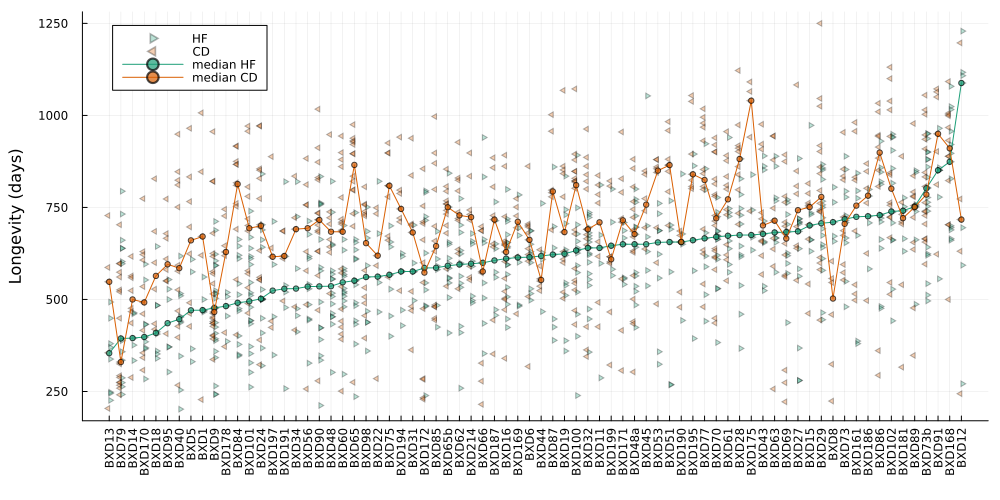

In [14]:
using Plots.PlotMeasures
@df subset(lifespanN4,:diet=>(x->x.=="HF")) dotplot(:medianOrder.+0.1,:lifetime,size=(1000,500),side=:right,mode=:none,
    markersize=4,markershape=:rtriangle,palette=:Dark2_4,markeralpha=0.3,bottom_margin=10mm,left_margin=5mm,label="HF",ylabel="Longevity (days)")
@df subset(lifespanN4,:diet=>(x->x.=="CD")) dotplot!(:medianOrder.-0.1,:lifetime,side=:left,mode=:none,
    markersize=4,markershape=:ltriangle,markeralpha=0.3,markercolor=2,label="CD")
@df strainDietTableN4Wide plot!(:medianOrder,:median_HF,
    markersize=3,markershape=:circle,markeralpha=0.7,linecolor=1,markercolor=1,label="median HF")
@df strainDietTableN4Wide plot!(:medianOrder,:median_CD,
    markersize=3,markershape=:circle,markeralpha=0.7,linecolor=2,markercolor=2,label="median CD")
@df strainDietTableN4Wide xticks!(:medianOrder,:strain,xrotation=90)

## Histogram of lifetimes

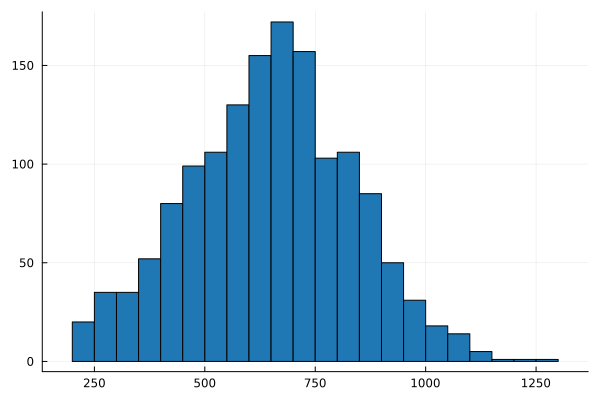

In [15]:
histogram(lifespanN4.lifetime,label="",palette=:tab10)

### Violin plot of lifetimes

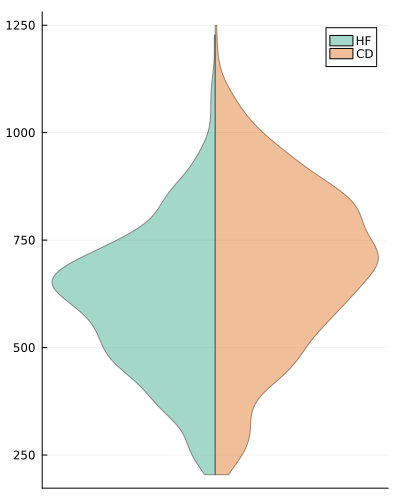

In [16]:
@df subset(lifespanN4,:diet=>(x->x.=="HF")) violin(ones(length(:lifetime)),:lifetime,label="HF",side=:left,xtick=:none,palette=:Dark2_4,alpha=0.4)
@df subset(lifespanN4,:diet=>(x->x.=="CD")) violin!(ones(length(:lifetime)),:lifetime,label="CD",side=:right,alpha=0.4,size=(400,500))

## Scatterplot of strain means by diet

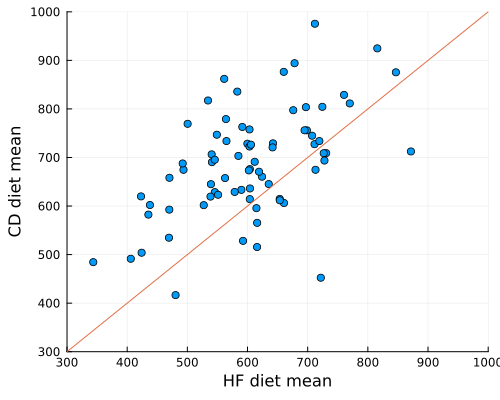

In [17]:
scatter(strainDietTableN4.mean[strainDietTableN4.diet.=="HF"],strainDietTableN4.mean[strainDietTableN4.diet.=="CD"],
    xlim=(300,1000),ylim=(300,1000),label="",xlab="HF diet mean",ylab="CD diet mean",size=(500,400))
plot!(x->x,label="")

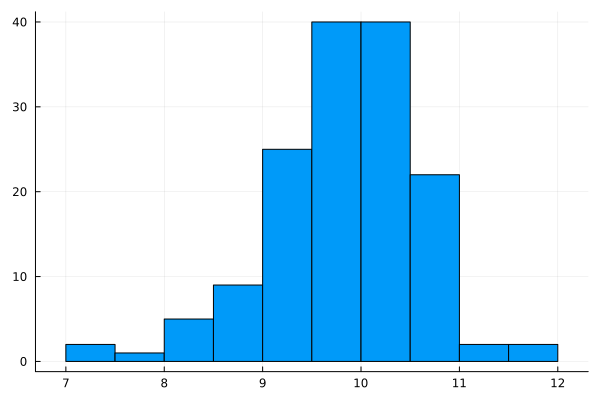

In [18]:
@df strainDietTableN4 histogram(log.(:sd.^2),label="")

# Linear mixed model

We now fit a linear mixed model with a random effect of strain, and a fixed effect of diet.

If $y_{ij}$ is the $j$-th observation in the $i$-th
strain, then we can write the linear model

$$y_{ij} = \mu + \delta t_{ij} + \beta_i + \epsilon_{ij},$$

where $\mu$ is a fixed effect of the overall mean and $\beta$'s are random effects with mean
zero and variance $\tau^2$. The idea now is to assume that the mean for each strain is now
random with mean $\mu$ and variance $\tau^2$. The residual error denoted by the $\epsilon$'s 
has variance $\sigma^2$. The variable $t_{ij}$ indicates whether the individual was given chow
or high-fat diet.

In [19]:
outLMM = fit(MixedModel,@formula(lifetime~1+diet+(1|strain)),
    lifespanN4,contrasts=Dict(:strain => StatsModels.FullDummyCoding(),
        :diet => EffectsCoding()));

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter ~/.julia/packages/ProgressMeter/sN2xr/src/ProgressMeter.jl:618
Minimizing 27 	 Time: 0:00:00 (13.68 ms/it)


In [20]:
outLM = fit(LinearModel,@formula(lifetime~1+diet+strain),
    lifespanN4,contrasts=Dict(:strain => EffectsCoding(),:diet => EffectsCoding()));

In [21]:
show(outLMM)

Linear mixed model fit by maximum likelihood
 lifetime ~ 1 + diet + (1 | strain)
   logLik   -2 logLik     AIC       AICc        BIC    
 -9502.3318 19004.6637 19012.6637 19012.6913 19033.7975

Variance components:
            Column    Variance  Std.Dev. 
strain   (Intercept)   7452.2797  86.3266
Residual              24821.4462 157.5482
 Number of obs: 1456; levels of grouping factors: 74

  Fixed-effects parameters:
──────────────────────────────────────────────────
               Coef.  Std. Error       z  Pr(>|z|)
──────────────────────────────────────────────────
(Intercept)  646.084    10.9619    58.94    <1e-99
diet: HF     -42.658     4.15951  -10.26    <1e-23
──────────────────────────────────────────────────

# Bayesian version of LMM

We now fit the Bayesian version of the LMM above.  It has the same form, with the
addition of priors for the unknown parameters.

We chose the priors as follows. We follow the current recommendation of using
_weakly informative_ priors instead of "non-informative" priors. These have the
advantage of guaranteeing that the posterior distributions are proper. They
can also be used to guide the posterior to explore relevant portions of the
parameter space.

- $\mu$ (overall mean): Normal with mean equal to the overall empirical mean, and twice the empirical sd.
- $\delta$ (diet effect): Normal with zero mean and save sd as overall mean.
- $\sigma$ (residual sd): Half Cauchy with scale parameter equal to empirical sd.
- $\tau$ (strain effect sd): Same as residual sd.
- $\beta$'s (strain effects): Normal with zero mean, and sd $\tau$.

In [ ]:
@model function linearMixedModel(y,strain,diet)
    stdy = std(y)
    nstrains = length(unique(strain))
    strainNames = sort(unique(strain))
    
    ndiets = length(unique(diet))
    dietNames = sort(unique(diet))
    
    μ ~ Normal(mean(y),stdy*2)
    δ ~ Normal(0.0,stdy*2)
    
    σ ~ truncated(Cauchy(0,stdy);lower=0)
    τ ~ truncated(Cauchy(0,stdy);lower=0)

    β ~ MvNormal( zeros(nstrains), I*τ^2 )
        
    strainEffectDict = Dict(zip(strainNames,β))
    strainMeans = (x->strainEffectDict[x]).(strain)
    dietEffectDict = Dict(zip(dietNames,[-δ/2,δ/2]))
    dietEffects = (x->dietEffectDict[x]).(diet)        
    means = μ .+ strainMeans .+ dietEffects
    
    y ~ MvNormal(means,I*σ^2)
    
end

In [ ]:
nstrains = length(unique(lifespanN4.strain))
meany = mean(lifespanN4.lifetime)
bayesLMM = @df lifespanN4 linearMixedModel(:lifetime,Vector(:strain),Vector(:diet));
bayesLMMStart = [ meany; -80.0; 130.0; 100.0; rand(Normal(0,50),nstrains) ];

In [ ]:
Random.seed!(123);
@time bayesLMMPostSample = sample(bayesLMM, 
    Gibbs(NUTS(200,0.65,init_ϵ=0.02,:μ,:δ,:σ,:τ),NUTS(200,0.65,init_ϵ=25.0,:β)),
    MCMCThreads(),1000,16,
    init_params = fill(bayesLMMStart,16));

In [ ]:
summarystats(bayesLMMPostSample) |> DataFrame

In [ ]:
plot(bayesLMMPostSample[:,1:5,:])

### Comparing LM estimates to LMM estimates

We can see that the LMM estimates are similar but shrunk towards zero.

In [ ]:
# ### Comparing Bayes, LMM, and LM methods

bayesRE = DataFrame(summarystats(bayesLMMPostSample))[5:end,1:3];
bayesRE.parameters = (sort(unique(lifespanN4.strain)));

lmmRE = raneftables(outLMM)[1] |> collect |> (x->DataFrame(x,:auto))
lmmRE.se = sqrt.(condVar(outLMM)[1][1,1,:]);
rename!(lmmRE,2=>"blup",1=>"strain");

effects = leftjoin(bayesRE,lmmRE,on=(:parameters=>:strain));

outLM = fit(LinearModel,@formula(lifetime~1+diet+strain),
    lifespanN4,contrasts=Dict(:strain => EffectsCoding(),:diet => EffectsCoding()));
lmEst = DataFrame(coeftable(outLM))[3:end,1:3];

transform!(lmEst,:Name => (s->replace.(s,r"^strain: " => s"")) => :Name)
rename!(lmEst,1=>:strain);

effects = leftjoin(effects,lmEst,on=(:parameters=>:strain));
sort!(effects,:parameters);
rename!(effects,1=>:strain,2=>:bayesEst,
    3=>:bayesSE,4=>:lmmEst,5=>:lmmSE,
    6=>:lmEst,7=>:lmSE);
effects.lmEst[1] = -sum(effects.lmEst[2:end]);

In [ ]:
@df effects scatter(:lmEst,:lmmEst,size=(500,400),label="",
    xlabel="LM estimate",ylabel="LMM estimate",framestyle=:box)
plot!(x->x,label="")

### Comparing LMM and Bayes estimates

We can see that they are virtually identical.

In [ ]:
@df effects scatter(:lmmEst,:bayesEst,size=(500,400),label="",
    xlabel="LMM estimate", ylabel="Bayes estimate", framestyle=:box)
plot!(x->x,label="")

# Relaxing normality assumption

If we are concerned about outliers, we may want to relax the normality 
assumption for the lifetimes.  This would be difficult with the LMM in
that no ready implementations are available.  We can do that in the
Bayesian version, by assuming that the lifetimes have a t-distribution
with 4 degrees of freedom.

## Density function comparison with same scale parameter

We can see that the t-distribution with 4 df has flatter tails compared to a Normal distribution
with the same (unit) scale parameter. This is the smallest df for which the t-distribution has
the first 3 moments.

In [ ]:
plot(TDist(4),label="t, df=4")
plot!(Normal(),label="Normal")
plot!(x->0,color=:black,label="")

The function to construct the joint distribution is virtually identical to the
previous one exceot for the very last line, where we make the outcome (lifetime)
conditional on the random effects to have a t-distribution with 4df.

In [ ]:
@model function linearMixedModelTDist(y,strain,diet)
    stdy = std(y)
    nstrains = length(unique(strain))
    strainNames = sort(unique(strain))
    
    ndiets = length(unique(diet))
    dietNames = sort(unique(diet))

    μ ~ Normal(mean(y),stdy*2)
    δ ~ Normal(0,stdy*2)

    σ ~ truncated(Cauchy(0,stdy);lower=0)
    τ ~ truncated(Cauchy(0,stdy);lower=0)

    β ~ MvNormal( zeros(nstrains), I*τ^2 )
        
    strainEffectDict = Dict(zip(strainNames,β))
    strainMeans = (x->strainEffectDict[x]).(strain)
    dietEffectDict = Dict(zip(dietNames,[-δ/2,δ/2]))
    dietEffects = (x->dietEffectDict[x]).(diet)        
    means = μ .+ strainMeans .+ dietEffects
    
    # y ~ arraydist( Normal()*σ .+ means )
    # Turing.@addlogprob! -nstrains*log(σ) + sum( (x->logpdf( TDist(12), x )).((y.-means)./σ) )
    y ~ arraydist( TDist(4)*σ .+ means )
    
end

To help the sampling, we initialize with starting values similar to that from the normal
residual LMM.

In [ ]:
bayesLMMTDist = @df lifespanN4 linearMixedModelTDist(:lifetime,:strain,:diet);
bayesLMMTDistStart = [ meany; -80.0; 130.0; 100.0; rand(Normal(0,50),nstrains) ];

We run NUTS with the stepsize parameter close to that for the normal model.  The idea
is that we expect the overall shape to be similar.

In [ ]:
Random.seed!(123);
@time bayesLMMTDistPostSample = sample(bayesLMMTDist, 
    Gibbs(NUTS(1000,0.65,init_ϵ=0.02,:μ,:δ,:σ,:τ),NUTS(1000,0.65,init_ϵ=25.0,:β)),
    MCMCThreads(),1000,16,
    init_params = fill(bayesLMMTDistStart,16));

In [ ]:
summarystats(bayesLMMTDistPostSample[:,:,:]) |> DataFrame

The chains seem to have converged, and different threads give about the same distribution.

In [ ]:
plot(bayesLMMTDistPostSample[:,1:7,:])

In [ ]:
bayesTDistRE = DataFrame(summarystats(bayesLMMTDistPostSample[:,:,:]))[5:end,1:3];
bayesTDistRE.parameters = (sort(unique(lifespanN4.strain)));

effects = leftjoin(bayesTDistRE,effects,on=(:parameters=>:strain))
rename!(effects,:parameters=>:strain,:mean=>:bayesTDistEst,:std=>:bayesTDistSE)

## Comparing LMM to Bayes estimates with t-distributed residuals

We see that there are some differences from the LMM (unlike the normal
residual Bayes model).  Overall, the estimates are still quite similar.

In [ ]:
@df effects scatter(:lmmEst,:bayesTDistEst,size=(500,400),label="",
    xlabel="LMM estimate", ylabel="Bayes t-dist estimate", framestyle=:box)
plot!(x->x,label="")

# Allowing strain variances to vary

Next, we make a second change in the model.  We allow the residuals to be normally distributed,
but we allow the variances to depend on the strain.  We use a hiearchical model for the variances
as follows.

- The strain variance for the $i$-th strain given the random effect is lognormal with 
  location parameter $\theta + \phi_i$ and scale parameter $\kappa$.
- The scale parameter $\kappa$ has a unit half Cauchy distribution.

In [ ]:
@model function linearMixedModelVar(y,strain,diet)
    stdy = std(y)
    nstrains = length(unique(strain))
    strainNames = sort(unique(strain))
    
    ndiets = length(unique(diet))
    dietNames = sort(unique(diet))
    
    # std of log within strain stds
    κ ~ truncated(Cauchy(0,1);lower=0)     
    # overall mean
    μ ~ Normal(mean(y),stdy*4)
    # diet effect
    δ ~ Normal(0,stdy*4)
    # std of strain random effects
    τ ~ truncated(Cauchy(0,stdy);lower=0)
    # within strain stds
    θ ~ Normal(log(stdy),4)
    ϕ ~ MvNormal( zeros(nstrains), I*κ^2 )
    # within strain means
    β ~ MvNormal( zeros(nstrains), I*τ^2 )
       
    strainEffectDict = Dict(zip(strainNames,β))
    strainVarDict = Dict(zip(strainNames,exp.(2.0.*(θ.+ϕ))))
    
    strainMeans = (x->strainEffectDict[x]).(strain)
    strainVars = (x->strainVarDict[x]).(strain)

    dietEffectDict = Dict(zip(dietNames,[-δ/2,δ/2]))
    dietEffects = (x->dietEffectDict[x]).(diet)        
    means = μ .+ strainMeans .+ dietEffects
    
    # y ~ arraydist( (x->Normal(x,σ)).(means) )
    y ~ MvNormal(means,Diagonal(strainVars))
    
end

In [ ]:
bayesLMMVar = @df lifespanN4 linearMixedModelVar(:lifetime,Vector(:strain),Vector(:diet));

We use starting values from the LMM, and for the scale parameter we use the two-step modeling of
the variances (see sections below).

In [ ]:
# @time lmmVarPostSample = sample(lmmVar,
#      Gibbs(NUTS(100,0.65,:β),NUTS(100,0.65,:θ),NUTS(100,0.65,:τ0,:τ2,:δ,:μ)),
#      MCMCThreads(),1000,16,init_params = fill(lmmVarMAP.values.array,16));
stdy = std(lifespanN4.lifetime)
meany = mean(lifespanN4.lifetime)
nstrains = length(unique(lifespanN4.strain))

bayesLMMVarStart = [ 0.4; meany; -80.0; 100.0; log(130.0); rand(Normal(0,0.1),nstrains); rand(Normal(0,50),nstrains) ];

In [ ]:
Random.seed!(123);
@time bayesLMMVarPostSample = sample(bayesLMMVar,
   Gibbs(NUTS(200,0.65,init_ϵ=0.02,:μ,:θ,:δ,:τ,:κ),NUTS(200,0.65,init_ϵ=25.0,:β),NUTS(200,0.65,init_ϵ=0.02,:ϕ)),
   MCMCThreads(),1000,16,init_params = fill(bayesLMMVarStart,16));

In [ ]:
summarystats(bayesLMMVarPostSample) |> DataFrame

The chain takes a few iterations to converge, but overall is mixing well; distributions across parallel chains
are similar.

In [ ]:
plot(bayesLMMVarPostSample[:,[1:6;70:72;151:153],:])

In [ ]:
bayesVarRE = DataFrame(summarystats(bayesLMMVarPostSample[101:1000,:,:]))[(74+6):end,1:3];
bayesVarRE.parameters = (sort(unique(lifespanN4.strain)));

effects = leftjoin(bayesVarRE,effects,on=(:parameters=>:strain))
rename!(effects,:parameters=>:strain,:mean=>:bayesVarEst,:std=>:bayesVarSE);

## Comparing LMM to Bayes estimates with heteroscedastic residuals

Heteroscedasticity appears to have little effect on the strain mean estimates
from the Bayes model.

In [ ]:
@df effects scatter(:lmmEst,:bayesVarEst,size=(500,400),label="",
    xlabel="LMM estimate", ylabel="Bayes t-dist estimate", framestyle=:box)
plot!(x->x,label="")

# Two-step models for the variances

Before I conducted the heteroscedastic analysis, I did a two-step analysis
for the variance heterogeneity to get a rough idea of the variability in the
within-strain variances.

My starting point was to look at the log of the variance using a LMM, but
quickly realized when I started writing the function, that the standard
machinery would not work (see below for function that I did not complete
writing).  The reason is that the log transformation is a variance stabilizing
transform for a variance, and in that case, the variance (of the sample variance)
is _known._

### Modeling the within-strain variances

```julia
function shrinkVar(v::Vector{Float64},n::Vector{Int64})
   
    logv = log.(v)
    logvmean = mean(logv)
    ϕ = 2.0./(n.-2)
    
    out = fit(MixedModel,@formula(logv~1+(1|strain)))
    λ = ϕ./(ϕ.+τ)
    logvShrink = (1.0.-λ) .* logv + λ.*logvmean
end
```

## Histogram of log strain variances

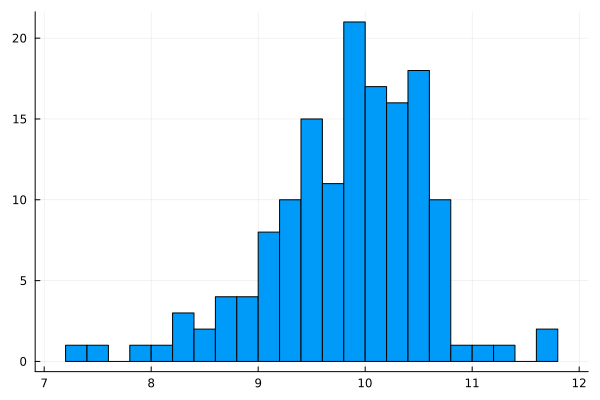

In [22]:
histogram(2*log.(strainDietTableN4.sd),bins=20,label="")

## Approximate distribution of log variances

It can be shown that the variance of the log sample variances is approximately 
$2/(n-2)$. We plot here the variance of the log of the variance from a normally
distributed outcome with sample size. We can see this from the figure below, that
the approximation is very good.

### Plot of variance of log of strain variance

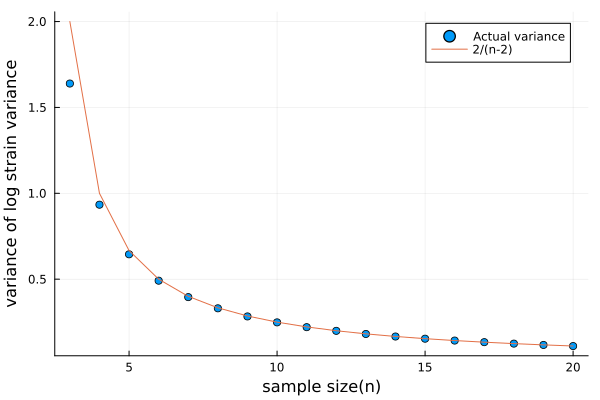

In [28]:
n = (3:20)
logVarN = n .|> (n->rand(Chisq(n-1),1_000_000)) .|> 
       (x->log.(x)) .|> 
       var
scatter(n,logVarN,ylabel="variance of log strain variance",
    xlabel="sample size(n)",label="Actual variance")
plot!(n,2 ./ (n.-2),label="2/(n-2)")

We can use this to model the log variances in a two-step Bayesian model.
Note that this has the same form as the earlier Bayesian LMM, just that it is on
the log strain variances, and we know the variance.

In [ ]:
@model function logvar(logv::Vector{Float64},n::Vector{Int64})
    k = length(logv)
    τ ~ truncated(Cauchy(0,1);lower=0)
    μ ~ Normal(mean(logv),10)
    β ~ MvNormal(zeros(k),I*τ^2)
    logv ~ MvNormal(μ.+β,Diagonal(2.0./(n.-2)))
end

In [ ]:
logVar = @df strainDietTableN4 logvar(log.(:sd.^2),:n);

In [ ]:
@time logVarPostSample = sample(logVar,NUTS(200,0.65,init_ϵ=0.02),MCMCThreads(),1000,16);

In [ ]:
summarystats(logVarPostSample) |> DataFrame

In [ ]:
plot(logVarPostSample[:,1:4,:])

These results suggest that although there is heterogeneity among the strains (in their
variance) the magnitude is small.  However, this modeling is based on an approximate
result, so we use a more direct Bayesian model that assumes that the strain variances
have a $\chi^2$ distribution.  This may be more palatable than assuming that the log
strain variances have a normal distribution.

## Modeling the variances directly

Instead of relying on the variance stabilizing transform, we can
directly model the variation in the variances. We assume that the
strain variances have a $\chi^2$ distribution with $n-1$ degrees of 
freedom.

In [ ]:
@model function shrinkvar(v::Vector{Float64},n::Vector{Int64})
    k = length(v)
    τ ~ truncated(Cauchy(0,1);lower=0)
    μ ~ Normal(mean(log.(v)),10)
    β ~ MvNormal(zeros(k),I*τ^2)
    v ~ arraydist( exp.(μ .+ β) .* (df->Chisq(df-1)).(n) )
end

In [ ]:
sv = @df strainDietTableN4 shrinkvar((:sd.^2),:n);

In [ ]:
@time svPostSample = sample(sv,NUTS(200,0.65,init_ϵ=0.002),MCMCThreads(),1000,16);

In [ ]:
summarystats(svPostSample) |> DataFrame

In [ ]:
plot(svPostSample[:,1:5,:])

The overall conclusion is the same as in the approximate analysis above.  We used
the value of $\tau$ here to suggest the starting value for $\kappa$ in the
heterscedastic analysis for the Bayesian LMM above.